In [14]:
import pandas as pd
import string

In [15]:
def replace_polish_lowercase(text):
    polish_to_latin = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n', 
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z'
    }
    return ''.join(polish_to_latin.get(char, char) for char in text)

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove polish letters
    text = replace_polish_lowercase(text)
    # Tokenize (split by whitespace)
    tokens = text.split()
    return ' '.join(tokens)  # Join tokens back into a string for TF-IDF

In [16]:
FILENAME_DEV = './data/dataset_conll/all.sentence.dev.txt'
FILENAME_TRAIN = './data/dataset_conll/all.sentence.train.txt'
FILENAME_TEST = './data/dataset_conll/all.sentence.test.txt'

LABELS = {
    "__label__z_minus_m": "Negative sentiment", 
    "__label__z_plus_m": "Positive sentiment",
    "__label__z_zero": "No sentiment",
    "__label__z_amb": "Unsure",
    }


In [17]:
def load_df(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        data = [line.strip() for line in lines]
        # get last word from each item as a label and match with data
        labeled_data = []
        for item in data:
            label = item.split()[-1]
            sentence_data = ' '.join(item.split()[:-1])
            labeled_data.append((sentence_data, LABELS[label]))

        # create a dataframe
        df = pd.DataFrame(labeled_data, columns=['sentence', 'label'])
        return df

# Read data

In [18]:
df_train = load_df(FILENAME_TRAIN)
df_test = load_df(FILENAME_TEST)

Early preprocessing

In [19]:
df_train['processed_sentence'] = df_train['sentence'].apply(preprocess_text)
df_test['processed_sentence'] = df_test['sentence'].apply(preprocess_text)

In [20]:
df_train.sample(5)

,sentence,label,processed_sentence
36875,Nie wiem z czym można mieć tu problem .,No sentiment,nie wiem z czym mozna miec tu problem
42650,"Pomijając bardzo mały wybór jedzenia , w dodat...",Negative sentiment,pomijajac bardzo maly wybor jedzenia w dodatku...
149,Od ponad roku używam koloru nr95 - Rose de Jas...,Positive sentiment,od ponad roku uzywam koloru nr95 rose de jaspe...
13673,Aha basen nie jest czynny caly dzien .,Negative sentiment,aha basen nie jest czynny caly dzien
14258,"Powiedział pan , że Dwór Kombornia wpisuje się...",No sentiment,powiedzial pan ze dwor kombornia wpisuje sie w...


# Classification

In [21]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [22]:
import google.generativeai as genai
import os
import enum
from typing_extensions import TypedDict

class Choice(enum.Enum):
    Negative = "Negative sentiment"
    Positive = "Positive sentiment"
    NoSentiment = "No sentiment"
    Unsure = "Unsure"
class Sentiment(TypedDict):
    sentence_id: int
    sentiment: Choice
    
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-flash")
generation_config={"response_mime_type": "application/json",
                   "response_schema": list[Sentiment]}


In [23]:
output_dir = "output/output_chunks"
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

    chunks = [df_test.iloc[i:i + 400] for i in range(0, len(df_test), 400)]

    for i, chunk in enumerate(chunks):
        output_file = os.path.join(output_dir, f"chunk_{i + 1}.txt")

        query = '\n'.join(f"{index}: {row['processed_sentence']}" for index, row in chunk.iterrows())
        response = model.generate_content(
            ["Classify the sentiment for each sentence:", query],
            generation_config=generation_config
        )

        with open(output_file, "w", encoding="utf-8") as f:
            f.write(response.text)

In [24]:
import json

combined_data = []

for filename in os.listdir(output_dir):
    if filename.endswith('.txt'):
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            data = json.load(file)
            combined_data.extend(data)

output_filepath = os.path.join(output_dir, 'combined_data.json')
with open(output_filepath, 'w', encoding='utf-8') as output_file:
    json.dump(combined_data, output_file, indent=4)

In [25]:
df = pd.DataFrame(combined_data)
df.head()

,sentence_id,sentiment
0,0,Negative sentiment
1,1,Negative sentiment
2,2,No sentiment
3,3,Negative sentiment
4,4,Positive sentiment


LLM Accuracy: 0.75
LLM Precision: 0.75
LLM Recall: 0.75
LLM F1: 0.71


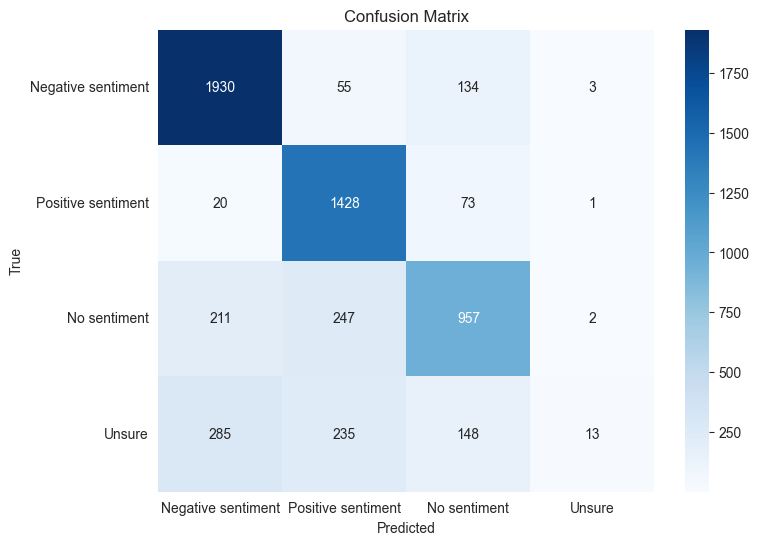

In [26]:
from util import model_summary, save_model_summary_dict, show_model_summary_dict

df_test['sentence_id'] = df_test.index
df_merged = pd.merge(df_test, df, on='sentence_id')
df_merged['match'] = df_merged['label'] == df_merged['sentiment']

summary = model_summary(df_merged['label'], df_merged['sentiment'], list(LABELS.values()), "LLM")
save_model_summary_dict(summary)
show_model_summary_dict(summary)
